# Exploring the UTx000 Extension Beacon Data
(See [GH repo](https://github.com/intelligent-environments-lab/utx000))

# Summary
This notebook helps look at the measurements taken during the study period for the various sensors on the beacons.

In [52]:
import warnings
warnings.filterwarnings('ignore')

# Package Import

In [53]:
import sys
sys.path.append('../')

from src.features import build_features, feature_engineering
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 200)
import scipy
import math
import geopy.distance

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm, ListedColormap, LinearSegmentedColormap

import seaborn as sns

from joypy import joyplot

from datetime import datetime, timedelta

# Data Import
Here are the relevant datasets

## Complete Beacon
The complete set of beacon data represented by the object `beacon`

In [54]:
beacon = pd.read_csv('../data/processed/beacon-ux_s20.csv',index_col=0,parse_dates=True)
#beacon_data = feature_engineering.limit_dataset(beacon_data, id_list=[1, 5, 6, 7, 10, 11, 15, 16, 17, 19, 21, 24, 25, 26, 28, 29, 34, 36, 38, 44])
beacon.head()

,tvoc,lux,no2,co,co2,pm1_number,pm2p5_number,pm10_number,pm1_mass,pm2p5_mass,pm10_mass,temperature_c,rh,beacon,beiwe,redcap
timestamp,,,,,,,,,,,,,,,,
2020-06-08 13:00:00,67.766667,3.614880,0.752363,13.922047,NaN,12.081799,11.458559,11.201085,0.744280,7.030832,1.935866,27.383333,46.586667,1,kyj367pi,10
2020-06-08 13:02:00,67.962500,3.643950,0.752363,13.906931,NaN,12.157965,11.542477,11.282880,0.750738,7.242373,1.940782,27.390625,46.581250,1,kyj367pi,10
2020-06-08 13:04:00,68.847059,3.635160,0.754480,13.893371,NaN,12.044653,11.436841,11.182763,0.742682,7.067631,1.937115,27.397059,46.597059,1,kyj367pi,10
2020-06-08 13:06:00,69.788889,3.587340,0.754725,13.874056,NaN,12.019940,11.401453,11.147062,0.739928,6.939538,1.933971,27.402778,46.619444,1,kyj367pi,10
2020-06-08 13:08:00,70.552632,3.582777,0.755032,13.862026,NaN,12.040436,11.431434,11.177380,0.742263,7.050378,1.936699,27.407895,46.639474,1,kyj367pi,10


## Nightly Beacon
The beacon data but only for the evenings when we have sleep events/data.

In [55]:
beacon_night = pd.read_csv("../data/processed/beacon_by_night-ux_s20.csv",index_col="timestamp",parse_dates=["timestamp","start_time","end_time"],infer_datetime_format=True)
beacon_night.head()

,tvoc,lux,no2,co,co2,pm1_number,pm2p5_number,pm10_number,pm1_mass,pm2p5_mass,pm10_mass,temperature_c,rh,beacon,beiwe,redcap,start_time,end_time,home,increasing_co2,ema
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-07-18 04:14:00,329.383333,0.0,NaN,0.0,1305.231544,7.697382,8.159313,8.206412,0.599577,4.095698,2.202808,29.0,35.0,46,nvtfpaor,33,2020-07-18 04:13:00,2020-07-18 12:40:30,-1,0.494024,0
2020-07-18 04:16:00,328.426667,0.0,NaN,0.0,1305.311871,7.708710,8.164054,8.210204,0.599828,4.088937,2.200515,29.0,35.0,46,nvtfpaor,33,2020-07-18 04:13:00,2020-07-18 12:40:30,-1,0.494024,0
2020-07-18 04:18:00,327.656667,0.0,NaN,0.0,1305.401755,7.764743,8.260294,8.311572,0.606119,4.166131,2.222169,29.0,35.0,46,nvtfpaor,33,2020-07-18 04:13:00,2020-07-18 12:40:30,-1,0.494024,0
2020-07-18 04:20:00,326.790000,0.0,NaN,0.0,1305.676844,7.681112,8.144458,8.191834,0.598659,4.093177,2.202454,29.0,35.0,46,nvtfpaor,33,2020-07-18 04:13:00,2020-07-18 12:40:30,-1,0.494024,0
2020-07-18 04:22:00,326.133333,0.0,NaN,0.0,1306.004997,7.628670,8.092455,8.140170,0.595414,4.078795,2.199446,29.0,35.0,46,nvtfpaor,33,2020-07-18 04:13:00,2020-07-18 12:40:30,-1,0.494024,0


### Occupied
We can further filter the nightly beacon dataset down by considering only times when the occupant is home according to `gps` data or the `co2` measurements are, on average, increasing.

In [56]:
beacon_night_occupied_temp = beacon_night[(beacon_night["home"] == 1) | (beacon_night["increasing_co2"] > 0.5)]

After manual inspection, there are also those nights that we have to exclude which is done in the following cell.

In [57]:
nights_to_exclude = pd.read_csv("../data/interim/bad_analysis_nights.csv")
for column in nights_to_exclude.columns:
    nights_to_exclude[column] = pd.to_datetime(nights_to_exclude[column])
    
temp = pd.DataFrame()
for pt in beacon_night_occupied_temp["beiwe"].unique():
    bb_pt = beacon_night_occupied_temp[beacon_night_occupied_temp["beiwe"] == pt]
    exclude_pt = nights_to_exclude.loc[:,pt]
    if len(exclude_pt) != 0:
        bb_pt = bb_pt[~bb_pt["start_time"].isin(exclude_pt)]
        
    temp = temp.append(bb_pt)
    
beacon_night_occupied = temp

### Occupied and EMA
Going even further, we can now filter down by whether or not participants completed the EMA the next day.

In [58]:
beacon_night_occupied_ema = beacon_night_occupied[beacon_night_occupied["ema"] == 1]

## Participant Information
We also need some important information regarding shipment dates to calculate completeness. So we import the beacon-specific ```id_crossover``` file.

In [59]:
details = pd.read_excel('../data/raw/utx000/admin/id_crossover.xlsx',sheet_name='beacon',index_col=1,
                       parse_dates=['start_date','end_date','move_date'])

# Insights
Here we look at the datasets on a higher level, including such things as:
- [which participants submitted data?](#submitted_data)
- [what data are available?](#available_data)
- [how much data were collected?](#collected_data)
- [what are typical measurements and what does this say?](data_summary)

<a id = "submitted_data"></a>

## Which participants submitted data?
Here we look at what beacons are represented in each of the three types of beacon datasets:
1. All available beacon data
2. Beacon data filtered by Fitbit-recorded sleep events when home (cross-references with GPS)
3. Beacon data from 2) further filtered by completed EMAs the next morning.

In [60]:
for dataset, label in zip([beacon, beacon_night, beacon_night_occupied, beacon_night_occupied_ema], ["complete","nightly","occupied","occupied_and_ema"]):
    print(f"{label.title().replace('_',' ')} Beacon Dataset")
    print(f'\tNumber of beacons represented:',len(dataset['beacon'].unique()))
    print(f'\tBeacons:',dataset['beacon'].unique())
    print(f'\tBeiwe:', dataset['beiwe'].unique())
    print()

Complete Beacon Dataset
	Number of beacons represented: 25
	Beacons: [ 1  5  6  7 10 11 15 16 17 19 21 22 24 25 26 28 29 30 32 34 36 38 40 44
 46]
	Beiwe: ['kyj367pi' '745vq78e' 'itmylz3g' 'zdpffrox' 'xlw5ntd5' 'i31pt4b4'
 '9jtzsuu8' 'e73a1pd5' '9xmhtq74' 'qh34m4r9' 'lkkjddam' 'xxvnhauv'
 'xdbdrk6e' 'vr9j5rry' 'awa8uces' 'hxj6brwj' 'tmexej5v' 'idbkjh8u'
 '2xtqkfz1' 'rnse61g4' 'tlmlq19s' 'olaxadz5' 'i4w8dx6l' '4i7679py'
 'nvtfpaor']

Nightly Beacon Dataset
	Number of beacons represented: 23
	Beacons: [46 21  6  7 19 29 10 30  1 16  5 26 25 38 34 44 15 24 11 28 36 17 40]
	Beiwe: ['nvtfpaor' 'lkkjddam' 'itmylz3g' 'zdpffrox' 'qh34m4r9' 'tmexej5v'
 'xlw5ntd5' 'idbkjh8u' 'kyj367pi' 'e73a1pd5' '745vq78e' 'awa8uces'
 'vr9j5rry' 'olaxadz5' 'rnse61g4' '4i7679py' '9jtzsuu8' 'xdbdrk6e'
 'i31pt4b4' 'hxj6brwj' 'tlmlq19s' '9xmhtq74' 'i4w8dx6l']

Occupied Beacon Dataset
	Number of beacons represented: 20
	Beacons: [46 21  6  7 19 29 10 30  1 16  5 26 25 38 34 44 15 24 11 36]
	Beiwe: ['nvtfpaor' 'lkkjd

<a id = "available_data"></a>

## What data are available?
Here we look at some basic visualizations to get a sense of the data collected

### Heatmaps by Sensor
These heatmaps show the values measured by a specific sensor on all of the beacons, but are more useful for determining when data are available.

In [61]:
def heatmaps_by_sensor(df=beacon,var_list=['pm2p5_mass','co2','co','no2','temperature_c','lux'],limit_list = [[1,75],[1,2000],[1,20],[1,100],[1,50],[0,600000]],log_scale=False,save=False):
    """
    Plots heatmaps for sensors in var_list
    """
    for variable, limits in zip(var_list, limit_list):
        print(f'Working for {variable}')
        heatmap_df = pd.DataFrame()
        for beacon in df['beacon'].unique():
            data_by_beacon = df[df['beacon'] == beacon]
            #data_by_beacon = data_by_beacon[data_by_beacon[variable] > 1]
            data_by_beacon = data_by_beacon.resample('1h').mean()
            sdate = datetime(2020,6,1)
            edate = datetime(2020,9,1)
            data_by_beacon = data_by_beacon[sdate:edate]
            heatmap_df = pd.concat([heatmap_df,data_by_beacon[variable]],axis=1)
            heatmap_df.rename(columns={variable:beacon}, inplace=True)

        print(f'\tData collected')
        fig, ax = plt.subplots(figsize=(20,15))
        df_to_plot = heatmap_df.T
        print(f'\tPlotting')
        if log_scale:
            sns.heatmap(df_to_plot,norm=LogNorm(vmin=np.nanmin(df_to_plot),vmax=np.nanmax(df_to_plot)))
        else:
            sns.heatmap(df_to_plot,vmin=np.nanmin(df_to_plot),vmax=np.nanmax(df_to_plot))

        x_labels = []
        for d in pd.date_range(sdate,edate-timedelta(days=1),freq='d'):
            x_labels.append(d.strftime('%m-%d'))

        ax.set_xticklabels(x_labels)

        plt.show()
        plt.close()

In [62]:
#heatmaps_by_sensor()

### Time Series Sensor Operation
Now we show individual beacons as a simplified time series to see that the sensors were operating.

In [63]:
def operation_and_data(df=beacon,sensors=['co2','pm2p5_mass','lux','no2','co','tvoc'],save=False):
    """
    
    """
    fig, axes = plt.subplots(10,5,figsize=(30,15),sharex="col",sharey='row')
    sensor_datapoints_dict = {'co2':0,'pm2p5_mass':0,'lux':0,'no2':0,'co':0,'tvoc':0}
    for bb, ax in enumerate(axes.flat):
        # restricting to participant
        beacon_by_beiwe = df[df['beacon'] == bb]
        if len(beacon_by_beiwe) > 2:
            beiwe = beacon_by_beiwe['beiwe'][0]
            beacon_by_beiwe = beacon_by_beiwe[details.loc[beiwe,'start_date']:details.loc[beiwe,'end_date']]
            limits = [-50,0,-10,-1000,-1000,-50]
            # Getting overall percentage of data completion
            total_datapoints = (details.loc[beiwe,'return_date'] - details.loc[beiwe,'start_date'] + timedelta(days=1)).days
            # x24 x60 to get into minutes, /5 for interverals, x6 for number of sensors
            total_datapoints = total_datapoints * 24 * 60 / 5 * len(sensors)
            available_datapoints = 0
            for sensor in sensors:
                available_datapoints += np.count_nonzero(~np.isnan(beacon_by_beiwe[sensor]))
                sensor_datapoints_dict[sensor] += np.count_nonzero(~np.isnan(beacon_by_beiwe[sensor]))
            total_percent = round(available_datapoints / total_datapoints * 100,1)

            i = 1
            for sensor, limit in zip(sensors,limits):
                beacon_by_beiwe[f'{sensor}_op'] = np.select([pd.to_numeric(beacon_by_beiwe[sensor],errors='coerce') > limit],[i])
                ax.scatter(beacon_by_beiwe.index,beacon_by_beiwe[f'{sensor}_op'],s=5,marker='s')
                i += 1
            # plotting start and stop dates
            ax.plot([details.loc[beiwe,'start_date'],details.loc[beiwe,'start_date']],[0,6],color='black',linestyle='dashed')
            ax.plot([details.loc[beiwe,'return_date']+timedelta(days=1),details.loc[beiwe,'return_date']+timedelta(days=1)],[0,6],color='black',linestyle='dashed')
            ax.text(datetime(2020,6,10),7,f'{beiwe}, B{bb}, {total_percent}%',va='center',ha='left')
            ax.set_ylim([0.5,7.5])
            ax.set_xlim([datetime(2020,6,1),datetime(2020,9,1)])
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
            ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[6,7,8]))
            ax.set_yticks(np.arange(1,7,1))
            ax.set_yticklabels(['CO$_2$','PM$_{2.5}$','Lux','NO$_2$','CO','TVOC'])
            for spine in ["top","right"]:
                ax.spines[spine].set_visible(False)
        else:
            ax.text(datetime(2020,6,10),7,f'B{bb}',va='center',ha='left')
            for spine in ["top","right"]:
                ax.spines[spine].set_visible(False)

    plt.subplots_adjust(hspace=0.1,wspace=0)
    if save:
        plt.savefig('../reports/utx000_initial_update/figures/time-beacon-sensor-operation-comprehensive.pdf')
        
    plt.show()
    plt.close()
    
    return total_datapoints, sensor_datapoints_dict

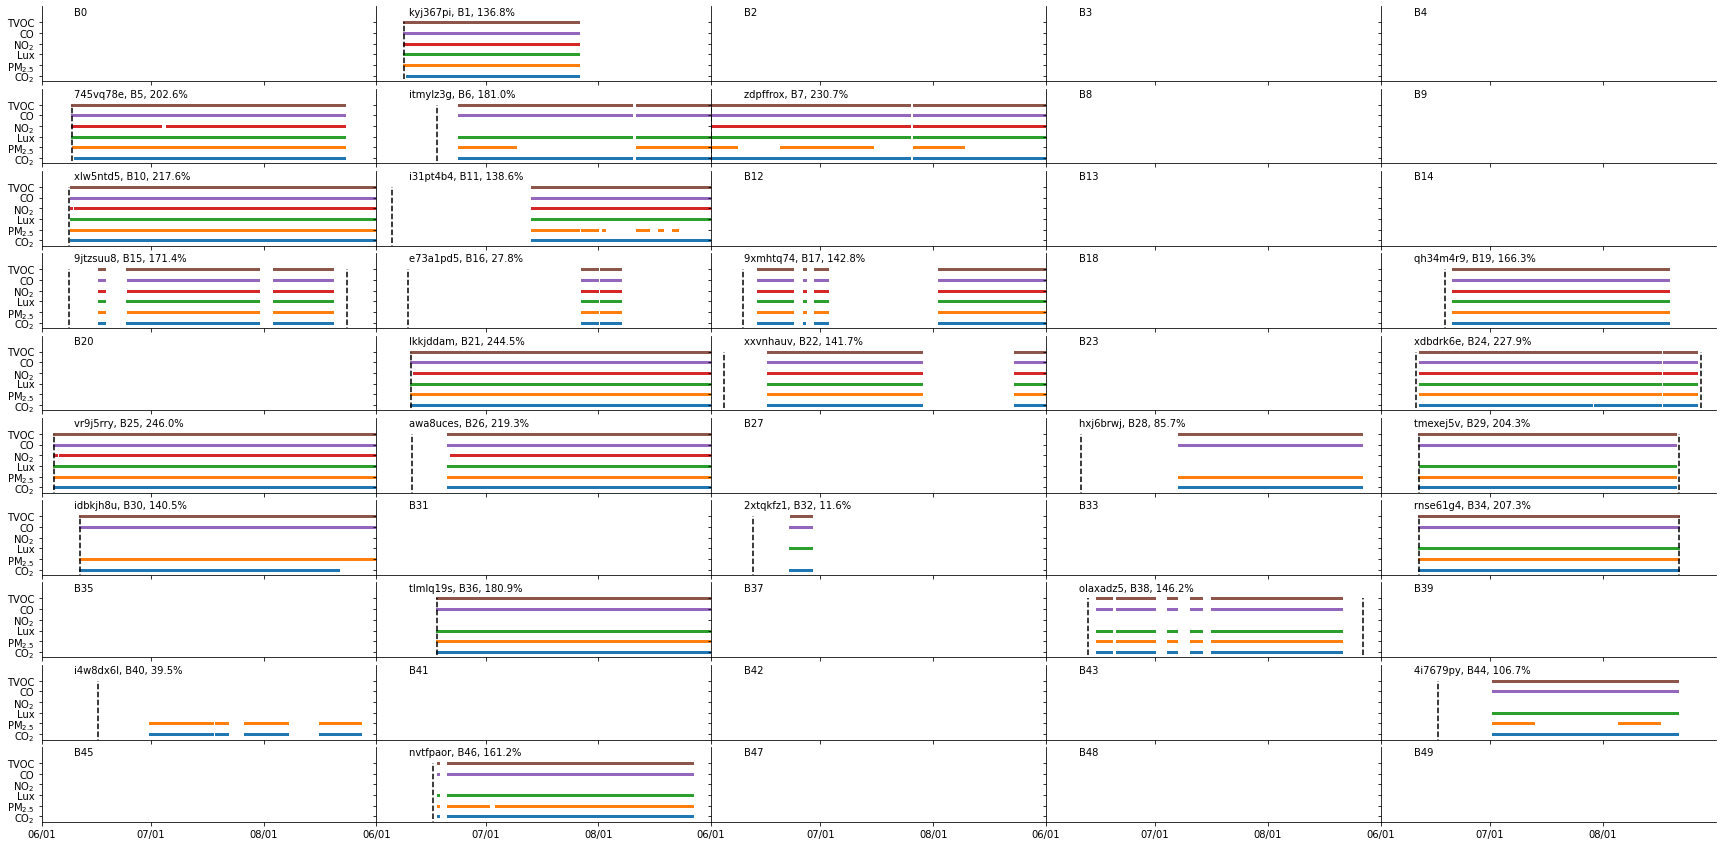

In [64]:
sensors = ['co2','pm2p5_mass','lux','no2','co','tvoc']
total_datapoints, sensor_datapoints_dict = operation_and_data(sensors=sensors)

### Heatmap per beacon
Now we can look at individual beacons and see how well they recorded during a specific time period. 

In [65]:
def create_cmap(colors,nodes):
    cmap = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
    return cmap

In [66]:
def heatmap_per_beacon(df=beacon,start_date=datetime(2020,7,6),end_date=datetime(2020,7,14),save=False):
    """
    Plots all beaecon data for a certain beacons during a specified time
    """
    for bb in df['beacon'].unique():
        beacon_bb = df[df['beacon'] == bb][start_date:end_date]
        if len(beacon_bb['no2']) > 10:
            print(f'{bb}:')
            beacon_bb = beacon_bb.resample('60T').mean()
            beacon_bb_pollutants = beacon_bb[['co2','pm2p5_mass','no2','co','tvoc','lux','temperature_c']]
            fig, axes = plt.subplots(7,1,figsize=(12,8),sharex=True)
            ylabels = ['CO$_2$',
                       'PM$_{2.5}$',
                       'NO$_2$',
                       'CO',
                       'TVOC',
                       'Light',
                       'T']
            cbar_ticks = [np.arange(400,1200,200),
                          np.arange(0,40,10),
                          np.arange(0,120,50),
                          np.arange(0,15,4),
                          np.arange(0,800,100),
                          np.arange(0,250,50),
                          np.arange(18,32,4)]
            cmaps = [create_cmap(["green", "yellow", "orange", "red",],[0.0, 0.33, 0.66, 1]),
                     create_cmap(["green", "yellow", "orange", "red"],[0.0, 0.2, 0.4, 1]),
                     create_cmap(["green", "yellow", "orange", "red"],[0.0, 0.33, 0.66, 1]),
                     create_cmap(["green", "yellow", "orange", "red"],[0.0, 0.375, 0.75, 1]),
                     create_cmap(["green", "yellow", "orange", "red"],[0.0, 0.1, 0.31, 1]),
                     create_cmap(["black","purple","red","orange","yellow","green"],[0.0, 0.1, 0.16, 0.2, 0.64, 1]),
                     create_cmap(["cyan","blue","green","orange","red"],[0.0, 0.2, 0.4, 0.7, 1])]
            for ax, var, low, high, ylabel, ticks, cmap in zip(axes,beacon_bb_pollutants.columns,[400,0,0,0,0,0,18],[1000,30,100,12,700,200,30],ylabels,cbar_ticks,cmaps):
                sns.heatmap(beacon_bb_pollutants[[var]].T,vmin=low,vmax=high,ax=ax,cbar_kws={'ticks':ticks},cmap=cmap)
                ax.set_ylabel(ylabel)
                ax.set_yticklabels([''])
                ax.set_xlabel('')

            xlabels = ax.get_xticklabels()
            new_xlabels = []
            for label in xlabels:
                new_xlabels.append(label.get_text()[11:16])

            ax.set_xticklabels(new_xlabels)
            plt.subplots_adjust(hspace=0.1)
            if save:
                plt.savefig('../reports/BuildSys2020/beacon_example.pdf')
            plt.show()
            plt.close()

In [67]:
#heatmap_per_beacon()

<a id = "collected_data"></a>

## How much data were collected?
Given the study period, we want to know how much of the possible data were collected

### Number of Hours
A nice metric would to be to see how many hours of data were collected. 

The number of hours is calculated as the sum of the hours each sensor on each beacon was operational.

In [68]:
# Number of beacons
n_beacons = len(beacon["beacon"].unique())
print(f"Number of beacons: {n_beacons}")
# Getting number of datapoints
n_datapoints = 0
print("Number of datapoints:")
for sensor in ['tvoc','lux','no2','co','co2','pm2p5_mass']:
    data_per_sensor = beacon.loc[:,sensor]
    data_per_sensor.dropna(inplace=True)
    print(f'\t{sensor}: {len(data_per_sensor)}')
    n_datapoints += len(data_per_sensor)
        
# datapoints are collected every five minutes, so we multiply the number of datapoints by 5 to get the minutes
n_hours = n_datapoints * 5 / 60
print(f'Number of hours of data collected: {n_hours}')
print(f'Number of days of data collected: {n_hours / 24}')

Number of beacons: 25
Number of datapoints:
	tvoc: 1093729
	lux: 983802
	no2: 653768
	co: 1107204
	co2: 1098078
	pm2p5_mass: 1119305
Number of hours of data collected: 504657.1666666667
Number of days of data collected: 21027.381944444445


<a id = "data_summary"></a>

## What are typical measurements?
Here we outline some functions to determine and visualize the dataset statistics:
* Summary Statistics
* Distributions
* Boxplots
* Correlation Matrix

In [69]:
def percent_possible(df, variables=['lux','temperature_c','rh','tvoc','co2','co','no2','pm2p5_mass'], resample_rate=2):
    """gets the percentage of operation for each sensor"""

    max_n = 0
    max_n_no2 = 0
    no2_beacons = []
    n_nights_max = 0
    for bb in df['beacon'].unique():
        beacon_pt = df[df['beacon'] == bb]
        starting_date = pd.to_datetime(details[details['beacon'] == bb]['start_date'].values[0])
        ending_date = pd.to_datetime(details[details['beacon'] == bb]['end_date'].values[0])
        if ending_date > datetime(2020,9,1):
            ending_date = datetime(2020,9,1)

        max_n += (ending_date - starting_date).total_seconds()/60/resample_rate
        n_nights_max += (ending_date.date() - starting_date.date()).days
        # Add no2 count
        if details[details['beacon'] == bb]['no2_sensor'].values[0] == 'Yes':
            max_n_no2 += (ending_date - starting_date).total_seconds()/60/resample_rate
            no2_beacons.append(bb)
        else:
            print(f'{bb}: no NO2 data')

    print(f'Number of Beacons with NO2 Sensors: {len(no2_beacons)}')
    
    op_period_df = pd.DataFrame()
    op_period_df['n'] = df[variables].count()
    op_period_df['max_n'] = max_n
    op_period_df['percent'] = df[variables].count()/max_n
    op_period_df.loc['no2','max_n'] = max_n_no2
    op_period_df.loc['no2','percent'] = op_period_df.loc['no2','n'] / max_n_no2
    return op_period_df

In [70]:
percent_possible(beacon_night)

46: no NO2 data
29: no NO2 data
30: no NO2 data
38: no NO2 data
34: no NO2 data
44: no NO2 data
28: no NO2 data
36: no NO2 data
40: no NO2 data
Number of Beacons with NO2 Sensors: 14


,n,max_n,percent
lux,136197,1277116.0,0.106644
temperature_c,138189,1277116.0,0.108204
rh,139435,1277116.0,0.109180
tvoc,138807,1277116.0,0.108688
co2,139144,1277116.0,0.108952
co,139846,1277116.0,0.109501
no2,89842,804031.5,0.111739
pm2p5_mass,144517,1277116.0,0.113159


In [71]:
def get_summary_stats(df, variables=['lux','temperature_c','rh','tvoc','co2','co','no2','pm2p5_mass'], name="all", save=False):
    """gets and save summary stats for beacon dataset"""
    stats = {'n':[],'avg':[],'med':[],'min':[],'25%':[],'75%':[],'95%':[]}
    precision = 1
    for variable in variables:
        li = df[variable].dropna().values
        stats['n'].append(len(li))
        stats['avg'].append(round(np.nanmean(li),precision))
        stats['med'].append(round(np.nanmedian(li),precision))
        stats['min'].append(round(np.nanmin(li),precision))
        stats['25%'].append(round(np.nanpercentile(li,25),precision))
        stats['75%'].append(round(np.nanpercentile(li,75),precision))
        stats['95%'].append(round(np.nanpercentile(li,95),precision))
        
    stats_df = pd.DataFrame(data=stats)
    stats_df.index = variables
    if save:
        stats_df.to_csv(f'../data/processed/beacon-{name}-summary_stats.csv')
        
    return stats_df

In [72]:
def plot_beacon_joyplots_by_stat(df,by_var='beacon',by_stat="mean",save=False,study_suffix="ux_s20",figure_note=""):
    '''
    Plots joyplots for the major sensors on the beacon. 
    
    Input:
    - df: DataFrame with data columns of data to plot
    - by_var: string of column used to separate the individual distributions by
    - by_stat: summary stat to order joyplots by
    
    Returns void
    '''
    variables = ['co2','pm2p5_mass','lux','no2','co','tvoc']
    units = ["Carbon Dioxide (ppm)","PM2.5 ($\mu$g/m$^3$)","Light Level (lux)","Nitrogen Dioxide (ppb)","Carbon Monoxide (ppm)"," TVOC (ppb)"]
    titles = ["a","b","c","d","e","f"]
    colors = ['cornflowerblue','grey','goldenrod','firebrick','pink','seagreen']
    limits = [[400,3000],[0,25],[0,100],[0,5],[0,12],[0,900]]
    beacons_to_leave_out = [[16,30],[],[],[],[11,46],[]]
        
    # looping through the variables 
    for var, color, limit, unit, title, bad_beacons in zip(variables, colors, limits, units, titles, beacons_to_leave_out):
        df_filtered = pd.DataFrame()
        for bb in df[by_var].unique():
            if bb in bad_beacons:# == "co2" and bb in [16,30]:
                continue
            else:
                temp = df[df[by_var] == bb]
                if by_stat == "median":
                    temp['stat'] = temp[var].median() + 0.0001*int(bb)
                else:
                    temp['stat'] = temp[var].mean() + 0.0001*int(bb)

                if math.isnan(temp['stat'][0]):
                    pass
                else:
                    df_filtered = df_filtered.append(temp)
            
        try:
            df_to_plot = df_filtered[[var,'stat',by_var]]
            ss = df_to_plot["stat"].unique()
            df_to_plot.sort_values(["stat"],inplace=True)
            labels = df_to_plot[by_var].unique()
            fig, ax = joyplot(data=df_to_plot,by='stat',column=[var],tails=0,
                kind='kde',overlap=0.5,ylim="own",range_style="own",x_range=limit,grid="y",
                labels=labels,alpha=0.75,color=color,figsize=(6,6))
            
            if save == True:
                plt.savefig(f'../reports/figures/beacon_summary/beacon-{var}-joyplot{figure_note}-{study_suffix}.pdf',bbox_inches="tight")

            plt.show()
            plt.close()
        except AssertionError as e:
            print("Something wrong with labeling")


In [73]:
def plot_beacon_boxplots_by_stat(df,by_var='beacon',by_stat="mean",save=False,study_suffix="ux_s20",figure_note=""):
    '''
    Plots joyplots for the major sensors on the beacon. 
    
    Input:
    - df: DataFrame with data columns of data to plot
    - by_var: string of column used to separate the individual distributions by
    - by_stat: summary stat to order joyplots by
    
    Returns void
    '''
    variables = ['co2','pm2p5_mass','lux','no2','co','tvoc']
    units = ["Carbon Dioxide (ppm)","PM2.5 ($\mu$g/m$^3$)","Light Level (lux)","Nitrogen Dioxide (ppb)","Carbon Monoxide (ppm)"," TVOC (ppb)"]
    titles = ["a","b","c","d","e","f"]
    colors = ['cornflowerblue','grey','goldenrod','firebrick','pink','seagreen']
    limits = [[400,3000],[0,10],[0,100],[0,3],[0,12],[0,800]]
    
    for var, color, limit, unit, title in zip(variables, colors, limits, units, titles):
        df_filtered = pd.DataFrame()
        for bb in df[by_var].unique():
            temp = df[df[by_var] == bb]
            temp['stat'] = temp[var].median() + 0.0001*int(bb)

            if len(temp) > 0:
                df_filtered = df_filtered.append(temp)
                
        fig, ax = plt.subplots(figsize=(20,8))
        df_filtered.sort_values("stat",inplace=True,ascending=False)
        sns.boxplot(x="stat",y=var,order=df_filtered["stat"].unique(),data=df_filtered)
        ax.set_xticklabels(df_filtered["beacon"].unique(),fontsize=14)
        ax.set_xlabel("")
        plt.yticks(fontsize=14)
        ax.set_ylabel(unit,fontsize=16)
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
            
        if save == True:
            plt.savefig(f'../reports/figures/beacon_summary/beacon-{var}-joyplot{figure_note}-{study_suffix}.pdf',bbox_inches="tight")
        plt.show()
        plt.close()

In [74]:
def plot_correlation_matrix_filtered(df,name="partially_filtered",variables = ['lux','temperature_c','rh','tvoc','co2','co','no2','pm2p5_mass'], save=False):
    """plots correlation matrix between variables"""
    df = df[variables]
    df.columns = ['Light','TVOC','NO$_2$','CO','T','RH','CO$_2$','PM$_{2.5}$']
    corr = df.corr()
    corr = round(corr,2)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    fig, ax = plt.subplots(figsize=(9, 7))
    sns.heatmap(corr, mask=mask, 
                     vmin=-1, vmax=1, center=0, 
                     cmap=sns.diverging_palette(20, 220, n=200),cbar_kws={'ticks':[-1,-0.5,0,0.5,1]},
                     square=True,linewidths=0.5,annot=True,ax=ax)

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
    
    yticklabels = ax.get_yticklabels()
    yticklabels[0] = ' '
    ax.set_yticklabels(yticklabels,rotation=0,ha='right',fontsize=14)

    xticklabels = ax.get_xticklabels()
    xticklabels[-1] = ' '
    ax.set_xticklabels(xticklabels,rotation=0,ha='center',fontsize=14)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    if save:
        plt.savefig(f'../reports/figures/beacon_{name}-correlation_matrix-ux_s20.pdf')
        plt.savefig(f'../../papers/60a81c09c88429592190c90b/figures/beacon_{name}-correlation_matrix-ux_s20.pdf',bbox_inches="tight")
    plt.show()
    plt.close()

In [75]:
def ts_inspection(df_in,variable,start_time,end_time,re=False,**kwargs):
    """plots timeseries data for certain variable"""
    df = df_in.copy()
    if "beacon" in kwargs.keys():
        df = df[df["beacon"] == kwargs["beacon"]]
        
    df.index = pd.to_datetime(df.index)
    fig, ax = plt.subplots(figsize=(24,4))
    df = df[start_time:end_time]
    ax.scatter(df.index,df[variable],color="black",s=5)
    # formatting
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)

    if re:
        return ax
    
    plt.show()
    plt.close()

In [76]:
def plot_data_availability_heatmap(df, df_filter='not', save=False, save_dir='../reports/figures/'):
    '''
    Plots a heatmap showing number of nights the various beacons measured for each sensor
    
    Inputs
    - df: dataframe with columns in columns_to_use
    - df_filter: the naming convention of the filtering applied to the beacon - used when saving
    - savefig: boolean specifying whether or not to save the file
    - save_dir: string of the location to save the figure
    
    Returns the count dataframe used to generate the heatmap
    '''
    # filtering the dataframe to only include import vars
    columns_to_use = ['lux','tvoc','co2','co','no2','pm2p5_mass','beacon','start_time']
    df_filtered = df[columns_to_use]
    # dict to store the values
    data = {'lux':[],'tvoc':[],'co2':[],'co':[],'no2':[],'pm2p5_mass':[],'beacon':[]}
    # looping through the dataframe to get the number of nights each beacon measured
    for bb in df_filtered['beacon'].unique():
        df_by_bb = df_filtered[df_filtered['beacon'] == bb]
        df_by_bb_by_night = df_by_bb.groupby('start_time').mean()
        for var in columns_to_use:
            if var == 'start_time':
                pass
            elif var == 'beacon':
                data['beacon'].append(bb)
            else:
                data[var].append(df_by_bb_by_night.count()[var])

    # formatting dataframe
    df_count = pd.DataFrame(data=data,index=data['beacon'])
    df_count.drop('beacon',axis=1,inplace=True)
    df_count.sort_index(inplace=True)
    
    # plotting heatmap
    fig, ax = plt.subplots(figsize=(12,5))
    sns.heatmap(df_count.sort_values(by='lux').T,square=True,annot=True,fmt="d",linewidths=.5,cmap="Blues",vmin=0,vmax=50,cbar_kws={"shrink":0.7,"pad":0.02},ax=ax)
    # reformatting figure labels
    ax.set_yticklabels(['Light','TVOC','CO$_2$','CO','NO$_2$','PM$_{2.5}$'],rotation=0)
    ax.set_xlabel('Participant/Beacon Number')
    ax.set_title('Number of Nights Measured by BEVO Beacon')
    
    # saving and showing
    if save:
        plt.savefig(f'{save_dir}beacon_{df_filter}_filtered-data_availability-heatmap-ux_s20.pdf',bbox_inches='tight')
    plt.show()
    plt.close()
    
    return df_count

### Complete Dataset
Now we look at the summary of data from the complete dataset.

In [77]:
get_summary_stats(beacon, save=False)

,n,avg,med,min,25%,75%,95%
lux,983802,23.6,2.0,0.0,0.0,11.5,58.0
temperature_c,1094526,25.8,27.0,0.0,25.5,28.3,29.5
rh,1098491,41.3,41.6,0.0,38.1,45.6,59.1
tvoc,1093729,266.7,242.1,0.0,150.3,347.0,545.9
co2,1098078,968.3,886.4,338.3,636.2,1196.5,1719.4
co,1107204,3.5,2.7,0.0,1.2,4.5,10.4
no2,653768,1.3,1.3,0.0,1.0,1.6,3.5
pm2p5_mass,1119305,4.4,3.6,0.0,1.9,5.7,10.9


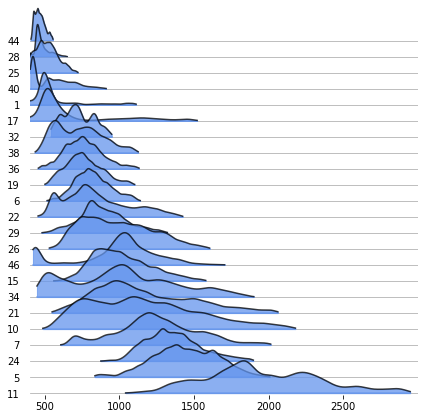

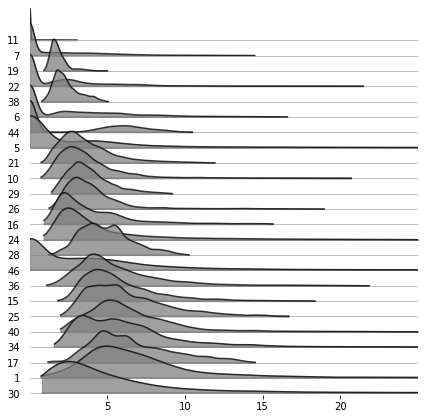

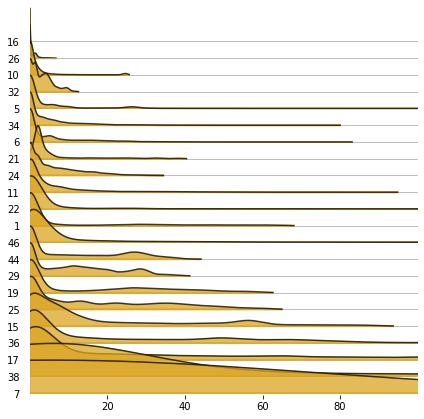

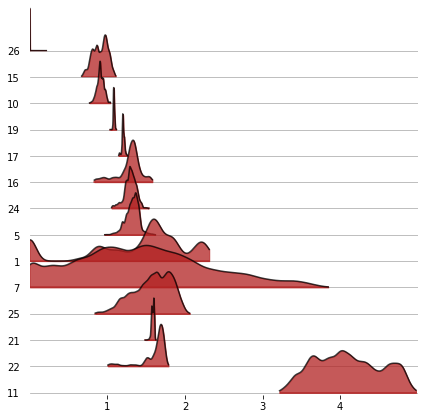

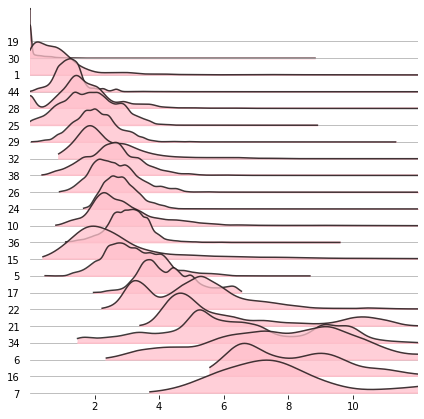

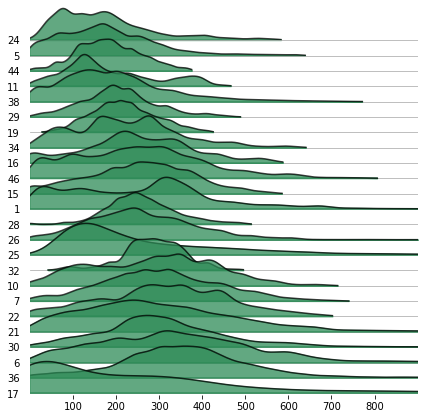

In [78]:
plot_beacon_joyplots_by_stat(beacon,by_stat="mean",save=False,figure_note="all")

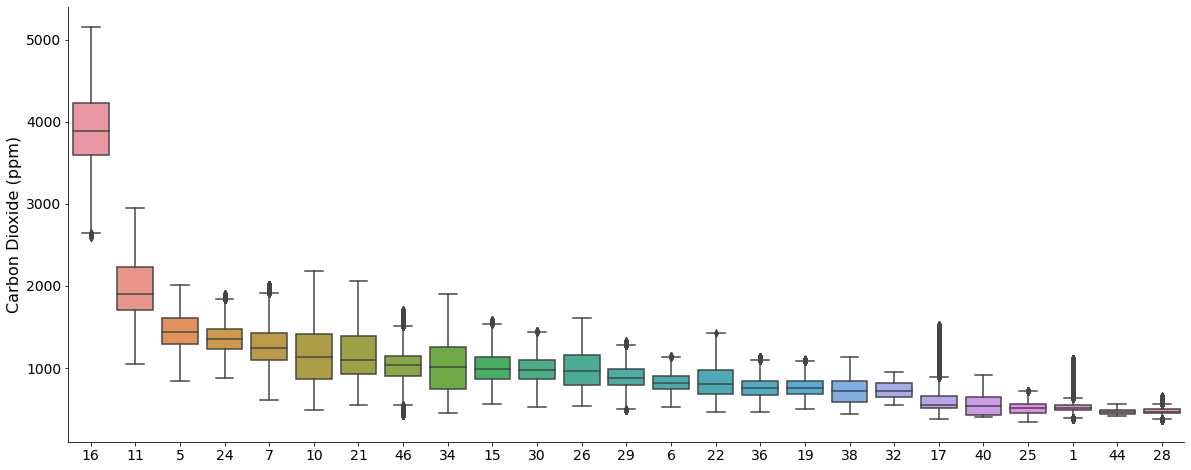

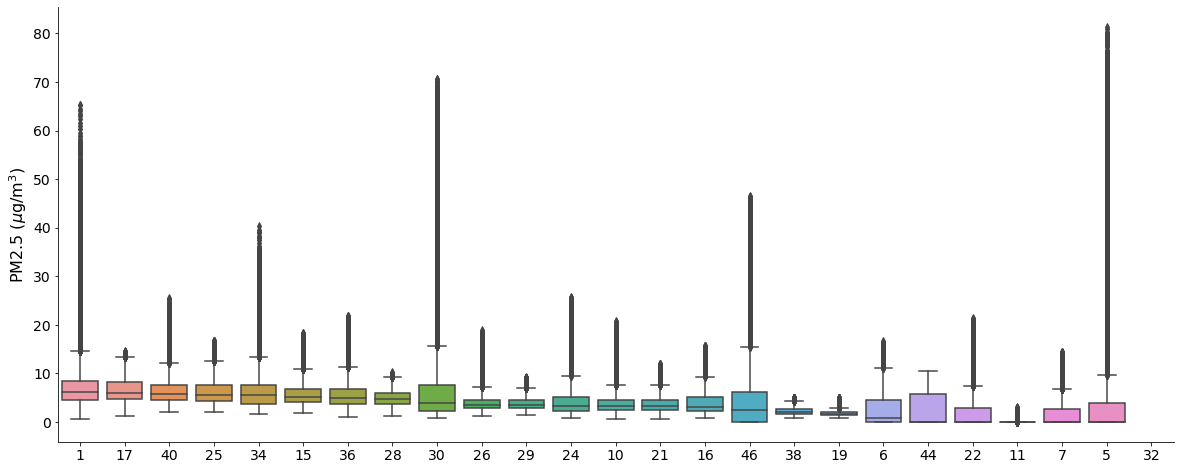

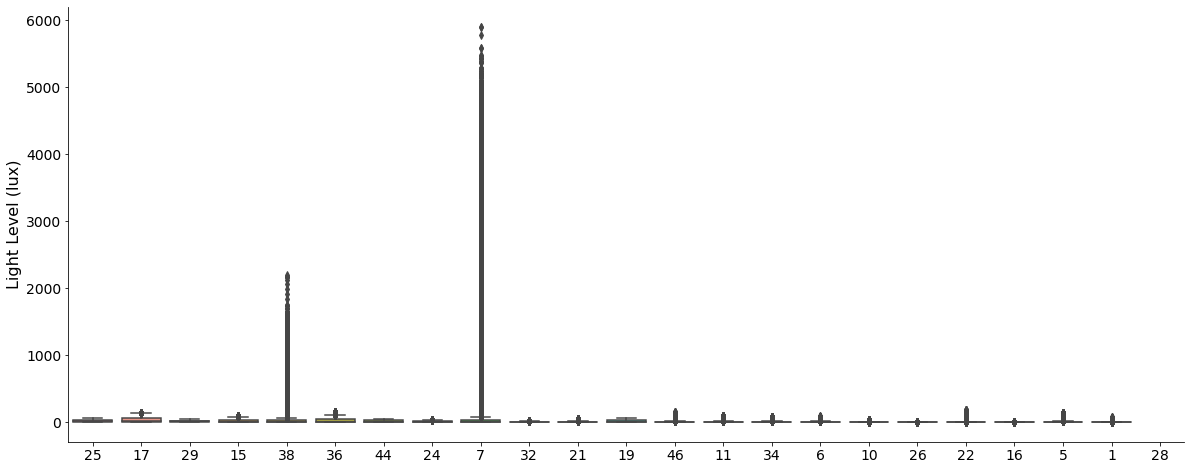

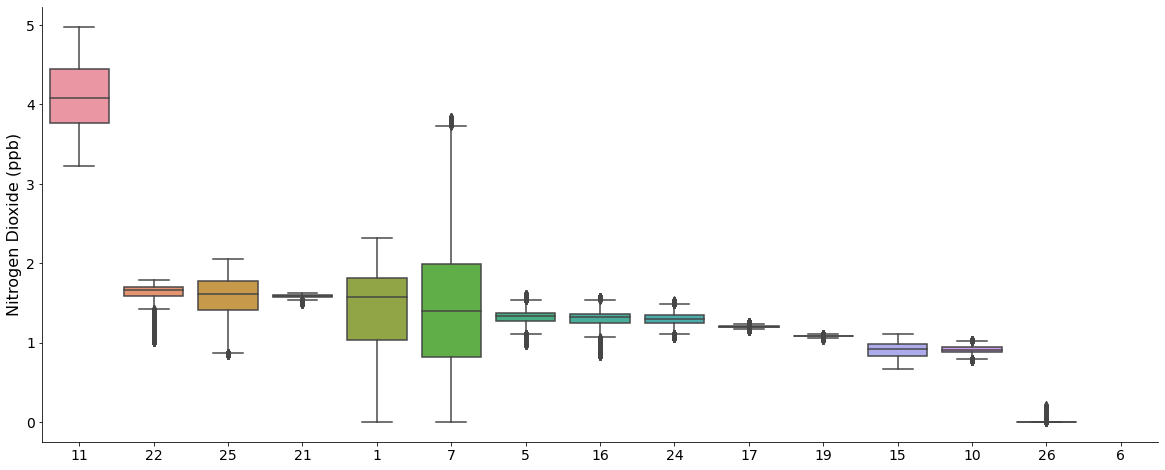

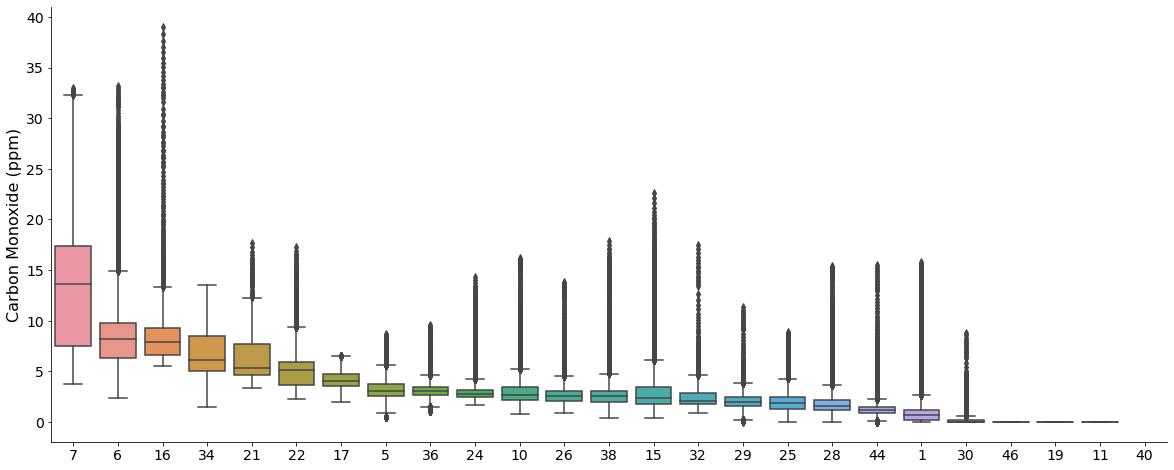

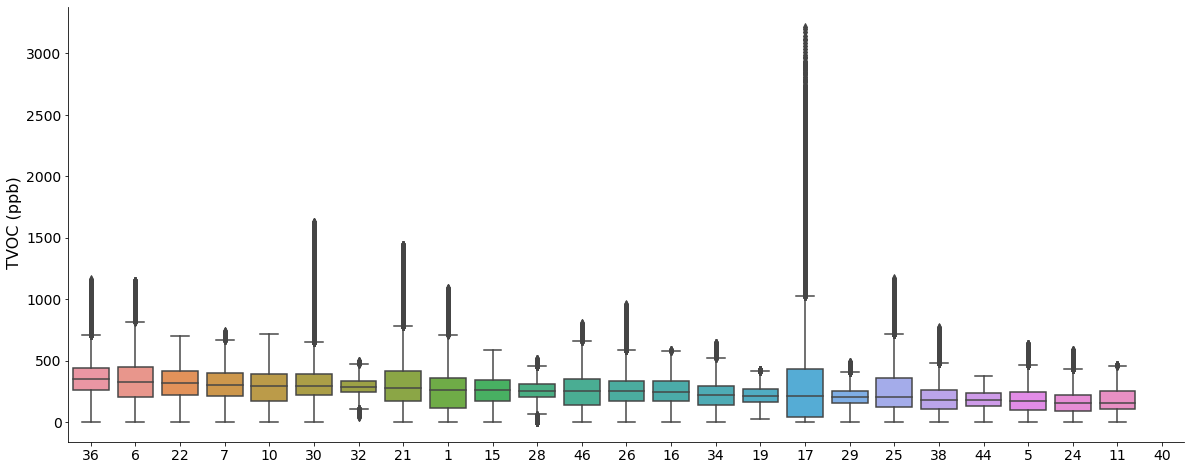

In [79]:
#plot_beacon_boxplots_by_stat(beacon, save=False)

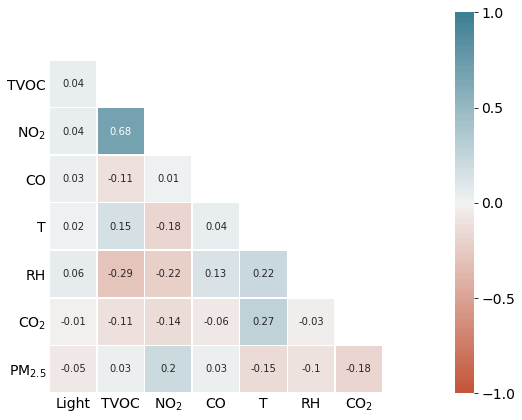

In [80]:
plot_correlation_matrix_filtered(beacon, name="all", save=False)

### Occupied Data Summary
The same analysis as above but only for time when the occupant is occupying the space.

In [81]:
print("Beacons:",sorted(beacon_night_occupied["beacon"].unique()))

Beacons: [1, 5, 6, 7, 10, 11, 15, 16, 19, 21, 24, 25, 26, 29, 30, 34, 36, 38, 44, 46]


In [82]:
temp = beacon_night_occupied.groupby(["beacon","start_time"]).median().reset_index()
print("Number of nights:", len(temp))
print("Number of individuals:", len(temp["beacon"].unique()))

Number of nights: 551
Number of individuals: 20


#### Data Completeness

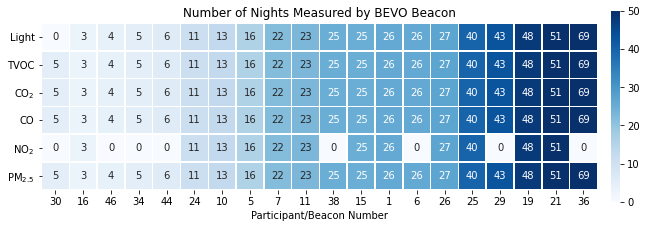

In [84]:
partially_filtered_nights = plot_data_availability_heatmap(beacon_night_occupied, df_filter='partially', save=True, save_dir="../../papers/5eea5276044b790001ee5687/figures/")

#### Summary Statistics/Distributions

In [36]:
get_summary_stats(beacon_night_occupied)

,n,avg,med,min,25%,75%,95%
lux,109593,5.1,0.0,0.0,0.0,1.5,9.8
temperature_c,109873,25.5,26.9,0.0,25.2,28.0,29.5
rh,110812,39.2,41.0,0.0,37.0,44.2,48.7
tvoc,110196,280.2,260.3,0.0,185.6,354.8,532.5
co2,107203,1036.8,917.6,394.7,766.5,1221.8,1871.3
co,111175,3.5,2.9,0.0,1.2,4.2,10.6
no2,69948,1.4,1.3,0.0,1.1,1.6,3.9
pm2p5_mass,110739,3.6,2.9,0.0,1.7,4.5,8.8


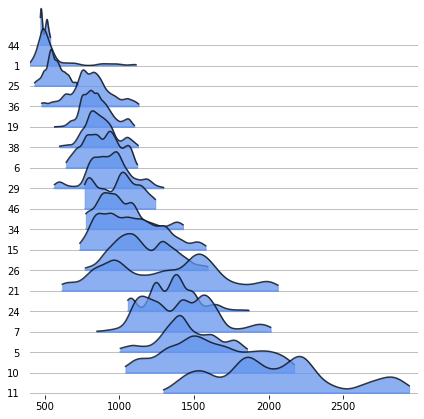

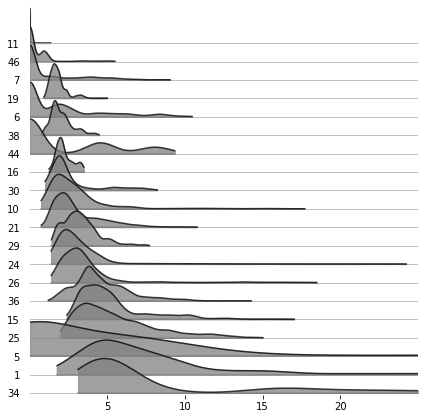

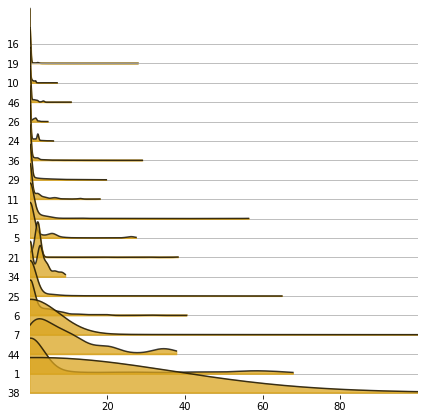

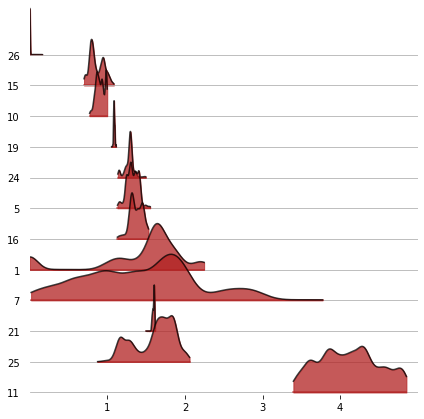

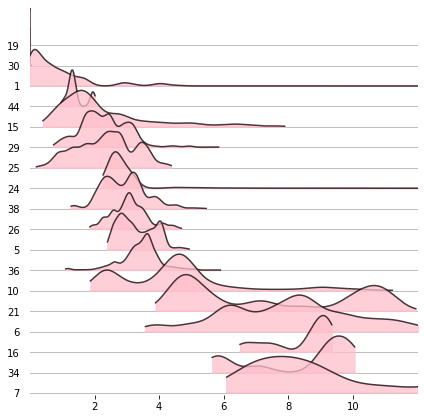

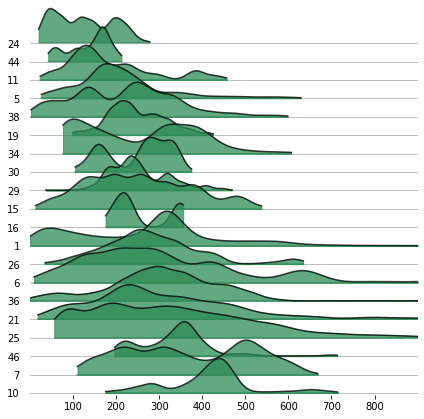

In [37]:
plot_beacon_joyplots_by_stat(beacon_night_occupied, save=False, figure_note="_partially_filtered")

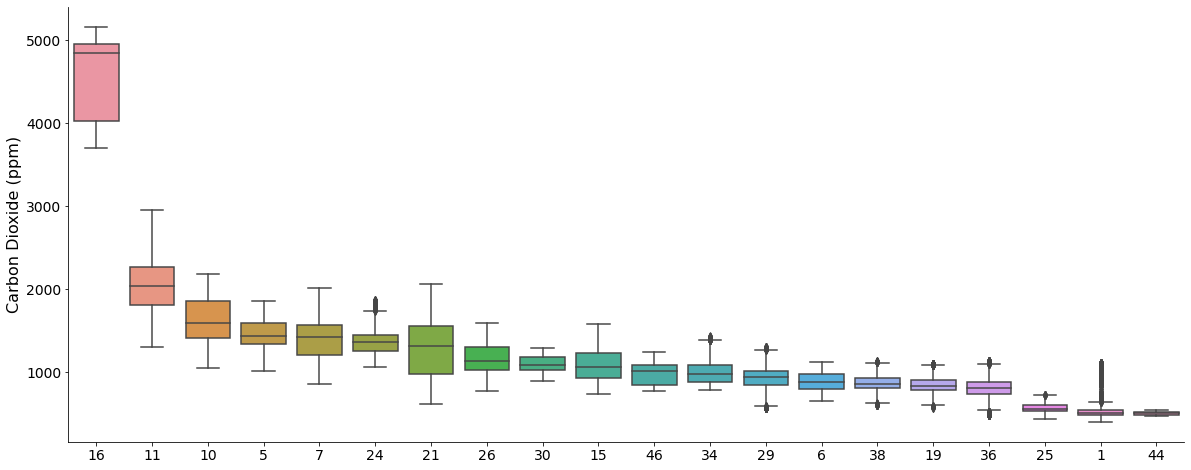

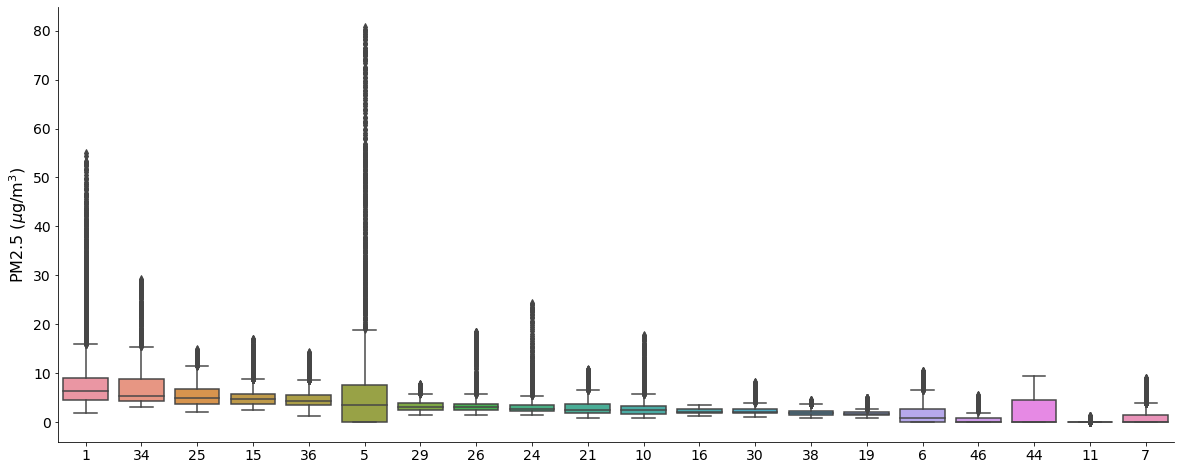

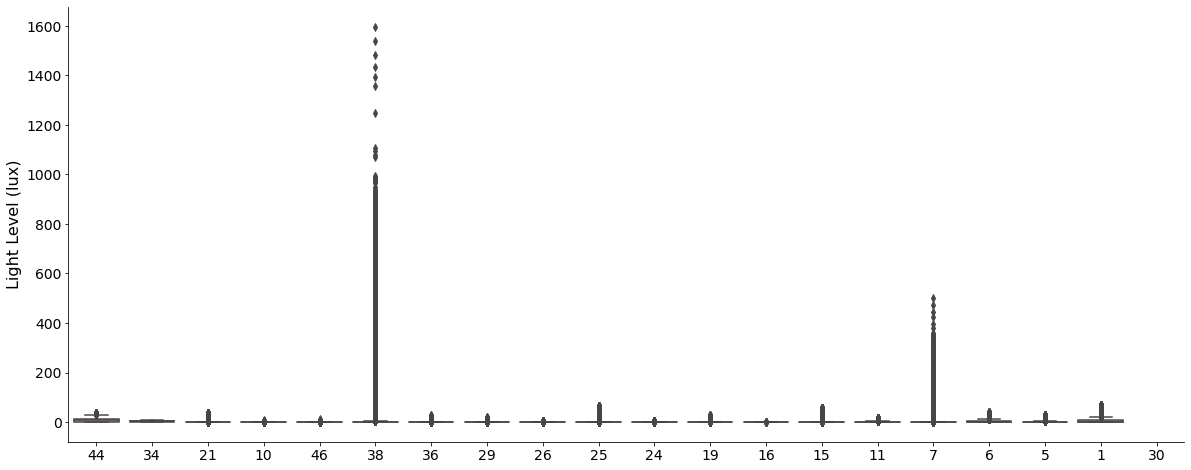

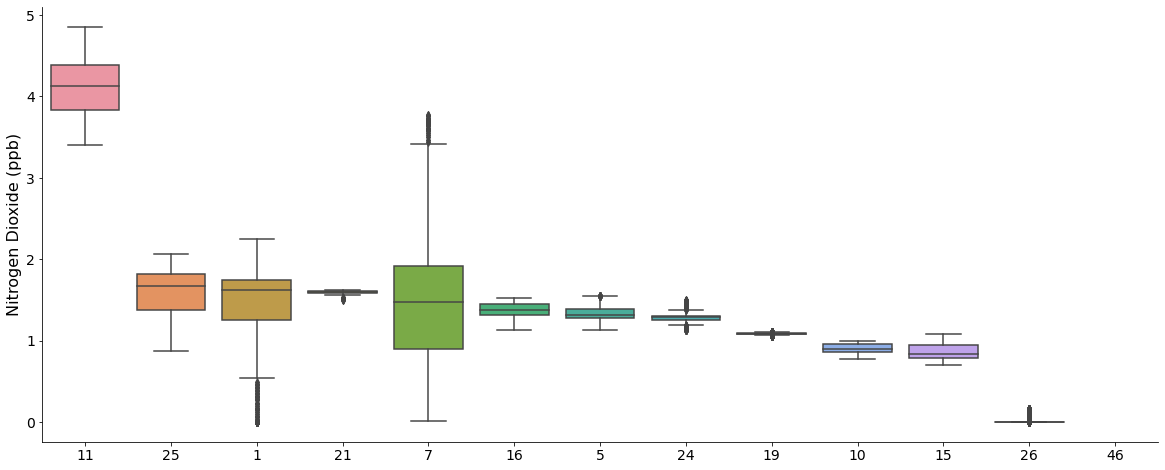

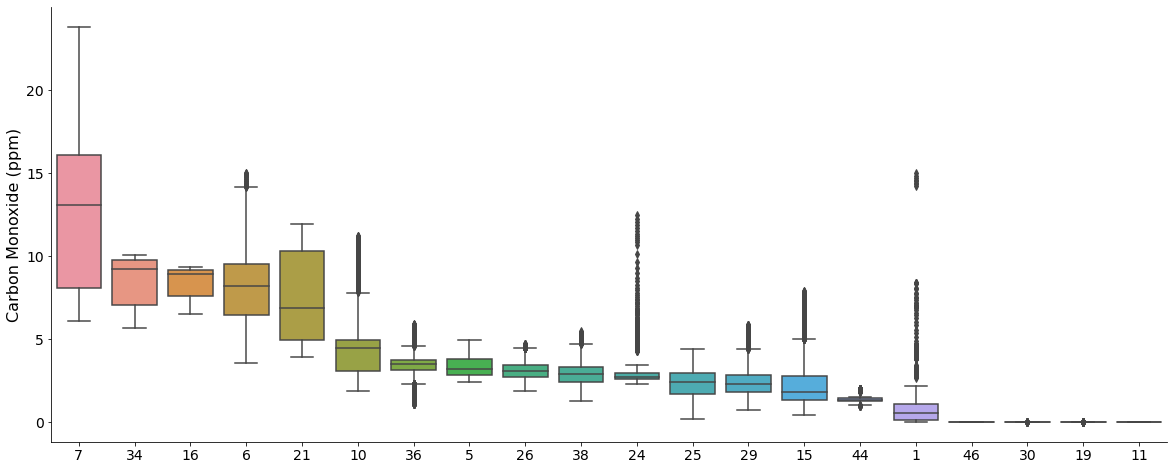

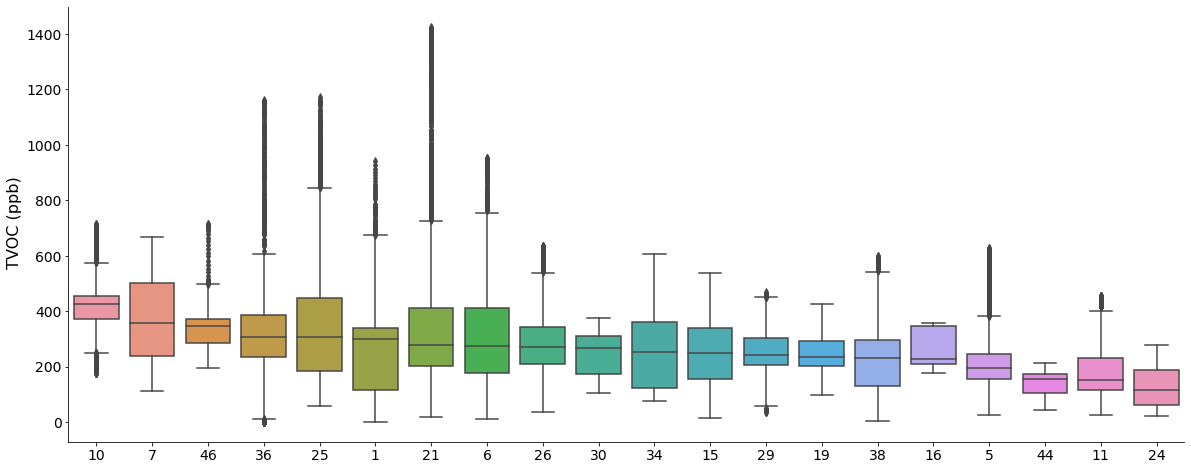

In [38]:
plot_beacon_boxplots_by_stat(beacon_night_occupied, save=False)

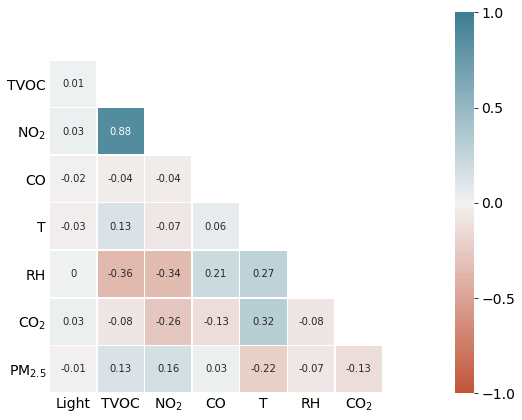

In [39]:
plot_correlation_matrix_filtered(beacon_night_occupied,save=False)

#### Inspecting
There were some odd results, primarily the `lux` readings for participant 38 and `no2` for participant 6.

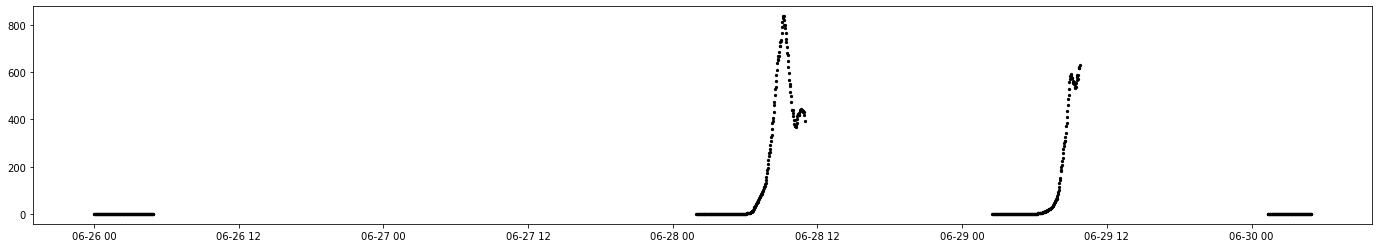

In [66]:
ts_inspection(beacon_night_occupied,start_time=datetime(2020,6,26),end_time=datetime(2020,7,1),variable="lux",beacon=38)

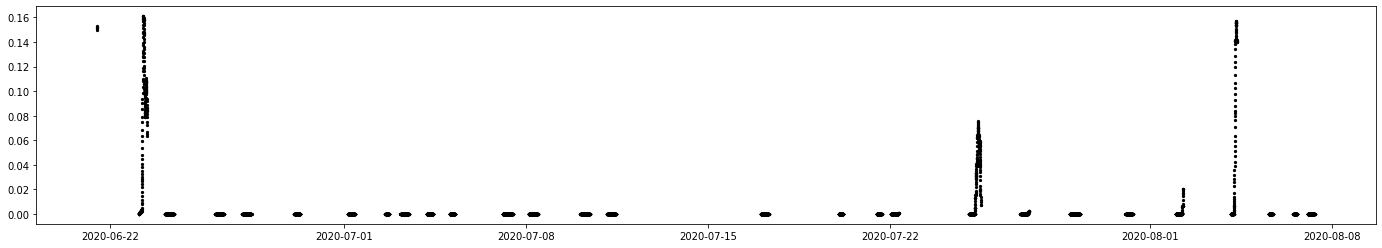

In [67]:
ts_inspection(beacon_night_occupied,start_time=datetime(2020,6,1),end_time=datetime(2020,9,1),variable="no2",beacon=26)

### Occupied Beacon Data for Nights when Participants Complete the EMA

In [71]:
get_summary_stats(beacon_night_occupied, save=False)

,n,avg,med,min,25%,75%,95%
lux,123719,5.5,0.0,0.0,0.0,2.0,19.8
temperature_c,124468,25.1,26.9,0.0,25.0,28.0,29.5
rh,125679,39.7,41.3,0.0,37.3,45.4,52.4
tvoc,124978,268.8,250.0,0.0,174.2,344.2,521.0
co2,121908,989.4,889.2,390.0,707.4,1154.5,1835.4
co,126194,3.5,2.9,0.0,1.3,4.2,10.5
no2,77096,1.4,1.2,0.0,1.1,1.6,3.8
pm2p5_mass,125965,3.6,3.1,0.0,1.7,4.7,8.7


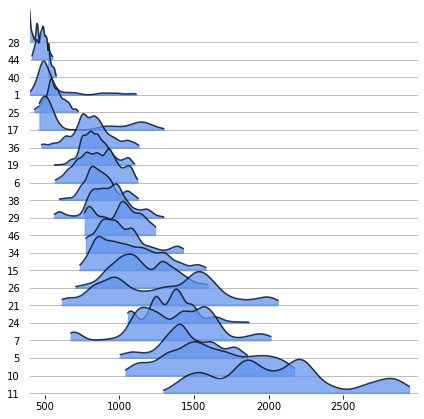

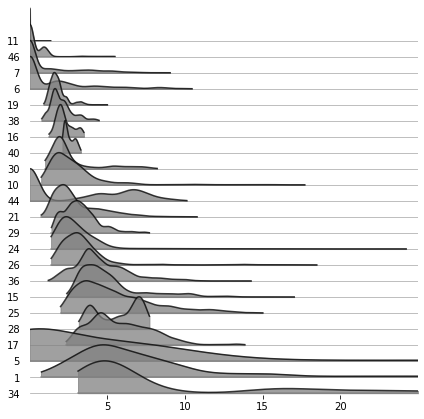

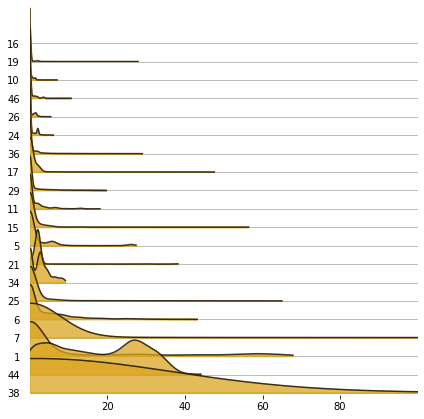

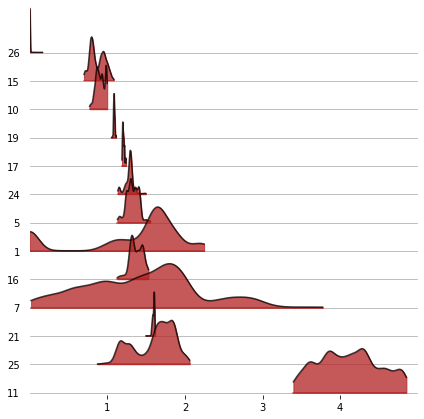

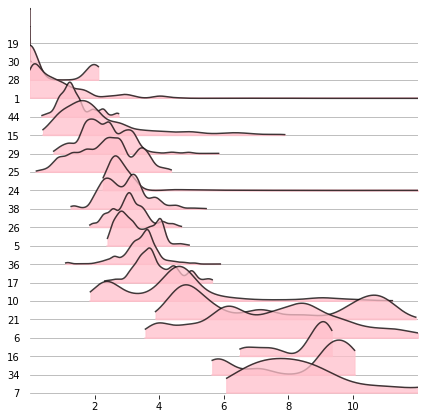

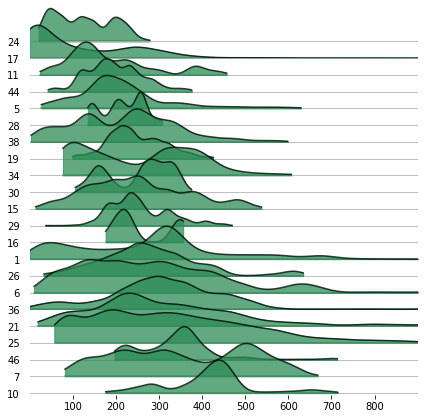

In [72]:
plot_beacon_joyplots_by_stat(beacon_night_occupied, save=False, figure_note="_fully_filtered")

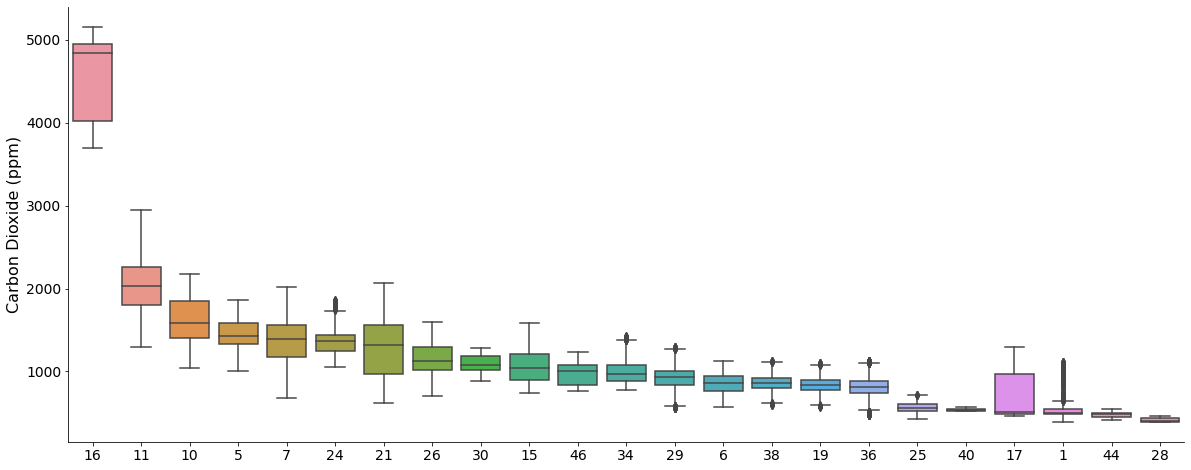

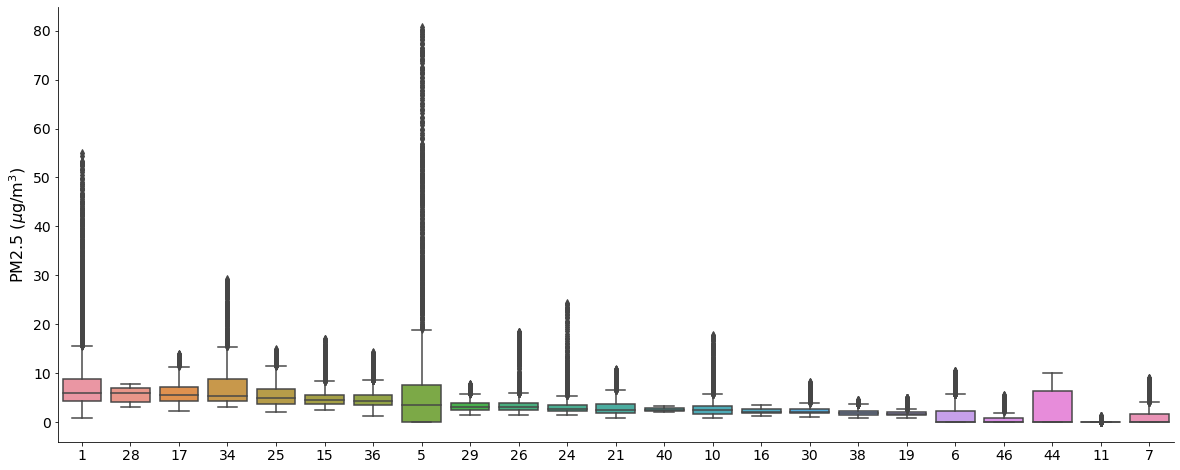

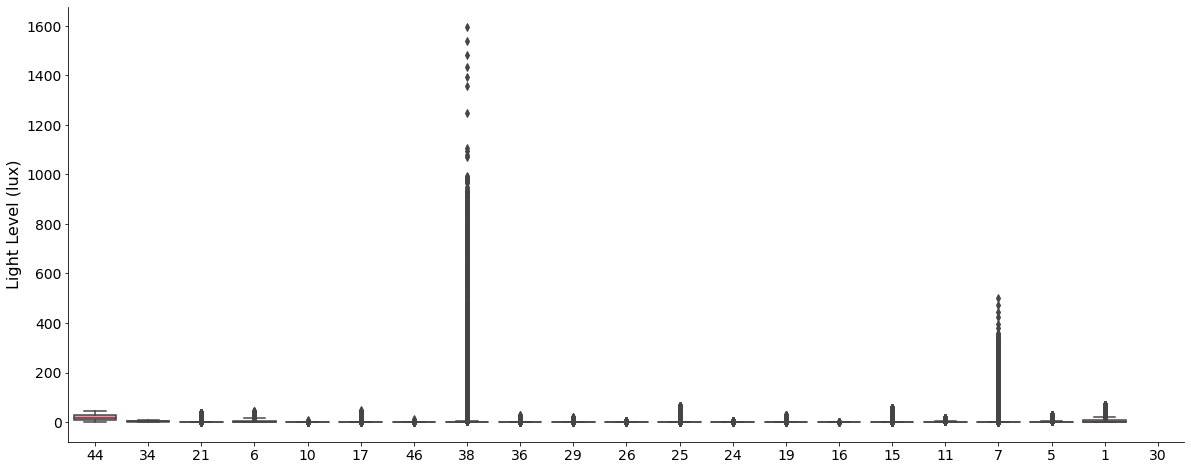

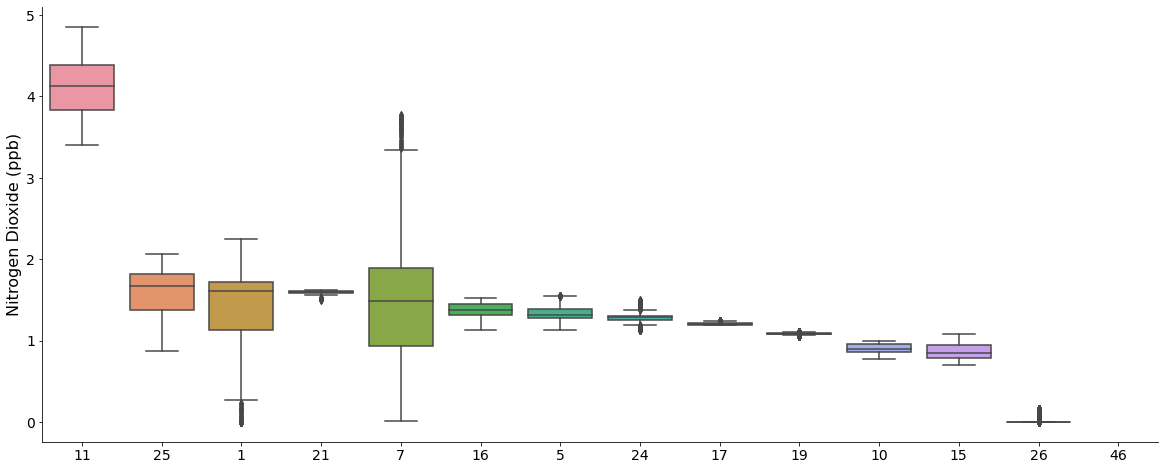

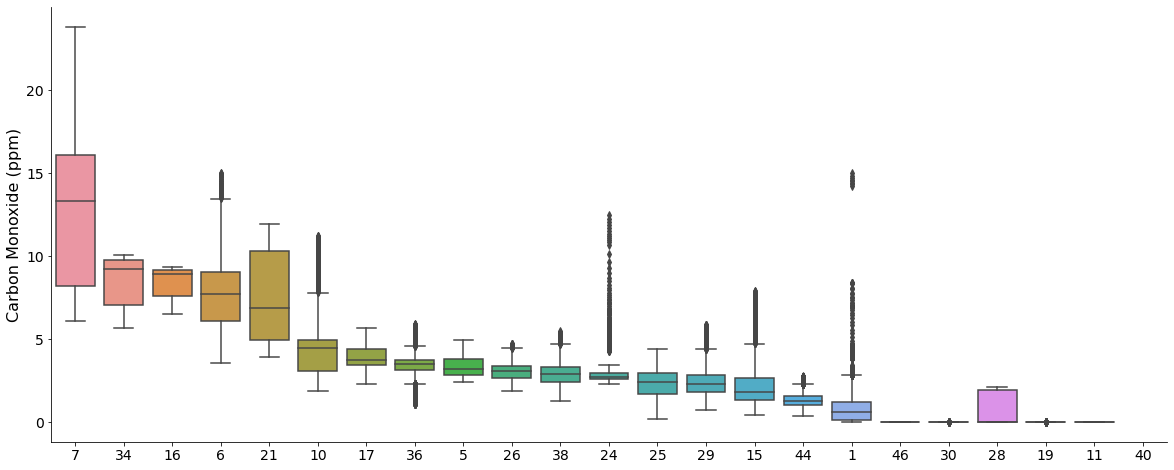

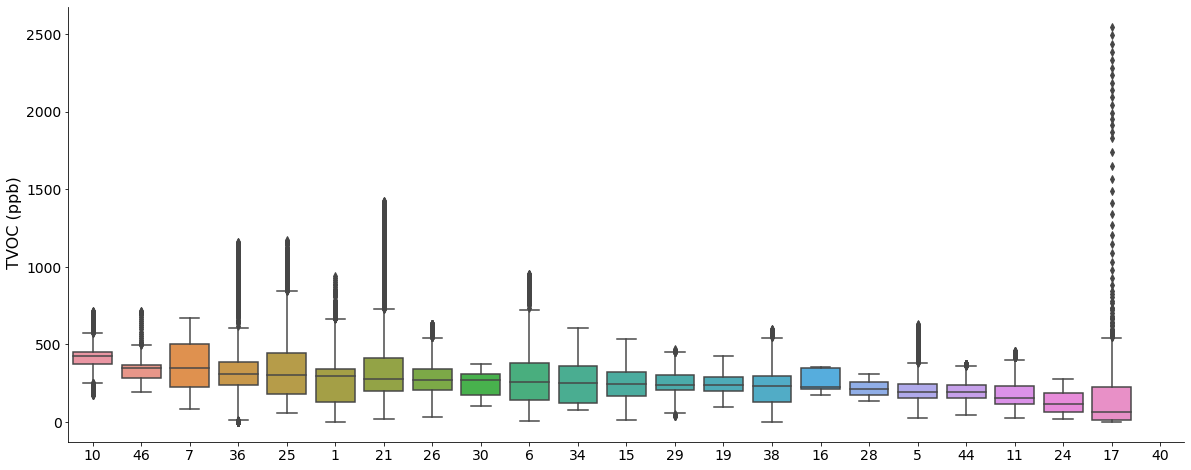

In [73]:
plot_beacon_boxplots_by_stat(beacon_night_occupied,save=False)

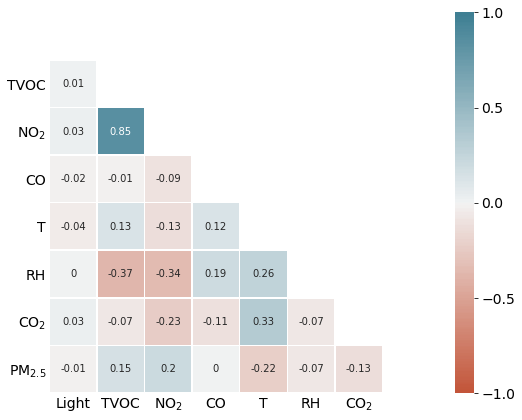

In [74]:
plot_correlation_matrix_filtered(beacon_night_occupied,name="fully_filtered",save=False)

# Data Completeness
We can also look at how complete the datasets are. There are two ways to summarize the completeness:
1. Percent of possible data collected over the study period i.e. while the participants had their respective devices
2. Percent of possible data collected while the beacon was actually operating. 
3. Percent of possible data collected when participants are home and asleep.
4. Percent of possible data collected when participants are home, asleep, and answered the survey the following morning. 


## Percent of Possible Data During Study Period
We first need to ensure that we have the correct start and stop periods for each individual. This information is housed in the ```details``` dataframe. 

We want to cross-reference the arrival date of the beacon to the individual and assume that is the start date. The end date can be changed to correspond to Sept. 1st or the return date - whatever happened first.  

In [75]:
overall_op = {}

### Number of Possible Nights
Another, related metric, is how many nights out of the possible we recorded data for each individual. We can use the same loop to determine the maximum number of nights.

In [76]:
variables = ['beacon','lux','tvoc','co2','co','no2','pm2p5_mass']
beacon_df = beacon[variables].sort_index()[:datetime(2020,9,1)]

max_n = 0
max_n_no2 = 0
no2_beacons = []
n_nights_max = 0
for bb in beacon_df['beacon'].unique():
    if bb not in [22,26,46]: # beacons with no Fitbit data or GPS data
        beacon_pt = beacon_df[beacon_df['beacon'] == bb]
        starting_date = pd.to_datetime(details[details['beacon'] == bb]['start_date'].values[0])
        ending_date = pd.to_datetime(details[details['beacon'] == bb]['end_date'].values[0])
        if ending_date > datetime(2020,9,1):
            ending_date = datetime(2020,9,1)

        max_n += (ending_date - starting_date).total_seconds()/60/5
        n_nights_max += (ending_date.date() - starting_date.date()).days
        # Add no2 count
        if details[details['beacon'] == bb]['no2_sensor'].values[0] == 'Yes':
            max_n_no2 += (ending_date - starting_date).total_seconds()/60/5
            no2_beacons.append(bb)
        else:
            print(f'{bb}: no NO2 data')
        
print(f'Number of Beacons with NO2 Sensors: {len(no2_beacons)}')

28: no NO2 data
30: no NO2 data
29: no NO2 data
34: no NO2 data
32: no NO2 data
38: no NO2 data
40: no NO2 data
44: no NO2 data
36: no NO2 data
Number of Beacons with NO2 Sensors: 13


Now that we have the max number of data points possible, we can divide the number of actual measurments by the count. We have to take special consideration for the NO2 sensor though since not all devices had one. 

In [241]:
op_period_df = pd.DataFrame()
op_period_df['n'] = beacon_df.count()
op_period_df['max_n'] = max_n
op_period_df['percent'] = beacon_df.count()/max_n
op_period_df.loc['no2','max_n'] = max_n_no2
op_period_df.loc['no2','percent'] = op_period_df.loc['no2','n'] / max_n_no2
op_period_df.drop('beacon',inplace=True)
op_period_df

,n,max_n,percent
lux,821021,422226.8,1.944502
tvoc,891822,422226.8,2.112187
co2,876854,422226.8,2.076737
co,836820,422226.8,1.981921
no2,525694,297914.4,1.764581
pm2p5_mass,744264,422226.8,1.762711


In [242]:
total_n = op_period_df['n'].sum()
total_max_n = op_period_df['max_n'].sum()
print(f'Total Percent Complete: {total_n/total_max_n}')

Total Percent Complete: 1.9495145884159066


Adding to overall operation

In [243]:
overall_op['During Study'] = list(np.around(op_period_df['percent'].values*100,1))
overall_op['During Study'].append(round(total_n/total_max_n*100,1))

Also with the max number of nights, we can look at the unique ending times of a person's sleep schedule to to get an idea of how many nights we did record.

In [244]:
print(f'Number of Possible Nights: {n_nights_max}')

Number of Possible Nights: 1476


## Percent of Possible Data while Operating
Now we look at when the beacon is powered on and see how much data was gathered

In [245]:
temp = beacon_df.drop(['beacon'],axis=1).dropna(how='all')
op_df = pd.DataFrame()
op_df['n'] = temp.count()
op_df['max_n'] = len(temp)
op_df['percent'] = temp.count()/len(temp)

Have to change up the approach for the NO2 sensor and only consider beacons with the sensor for ```max_n```

In [246]:
# dataframe with only beacons with NO2 sensors and removing times when all sensors measured nothing
no2_temp = beacon_df[beacon_df['beacon'].isin(no2_beacons)].drop(['beacon'],axis=1).dropna(how='all')
op_df.loc['no2','max_n'] = len(no2_temp)
op_df.loc['no2','percent'] = op_df.loc['no2','n'] / len(no2_temp)
op_df

,n,max_n,percent
lux,821021,905830,0.906374
tvoc,891822,905830,0.984536
co2,876854,905830,0.968012
co,836820,905830,0.923816
no2,525694,587316,0.895079
pm2p5_mass,744264,905830,0.821638


In [247]:
total_n = op_df['n'].sum()
total_max_n = op_df['max_n'].sum()
print(f'Total Percent Complete: {total_n/total_max_n}')

Total Percent Complete: 0.9179138491294577


Adding to overall op

In [248]:
overall_op['While Operating'] = list(np.around(op_df['percent'].values*100,1))
overall_op['While Operating'].append(round(total_n/total_max_n*100,1))

The number of nights recorded will be the same reported above:

In [249]:
print(f'Number of Possible Nights: {n_nights_max}')

Number of Possible Nights: 1476


## Percent of Possible Data while Asleep and At Homes
Now we look at an even smaller window of the nightly measured values - filtered by GPS and Fitbit

In [250]:
beacon_fitbit_important = beacon_fitbit[variables]
temp = beacon_fitbit_important.drop(['beacon'],axis=1).dropna(how='all')
night_op_df = pd.DataFrame()
night_op_df['n'] = temp.count()
night_op_df['max_n'] = len(temp)
night_op_df['percent'] = temp.count()/len(temp)

Considering NO2 only now

In [251]:
no2_temp = beacon_fitbit_important[beacon_fitbit_important['beacon'].isin(no2_beacons)].dropna(how='all')
no2_temp.drop(['beacon'],axis=1,inplace=True)
night_op_df.loc['no2','max_n'] = len(no2_temp)
night_op_df.loc['no2','percent'] = night_op_df.loc['no2','n'] / len(no2_temp)
night_op_df

,n,max_n,percent
lux,30052,31153,0.964658
tvoc,30793,31153,0.988444
co2,29732,31153,0.954386
co,25743,31153,0.826341
no2,16221,19380,0.836997
pm2p5_mass,25438,31153,0.816551


In [252]:
total_n = night_op_df['n'].sum()
total_max_n = night_op_df['max_n'].sum()
print(f'Total Percent Complete: {total_n/total_max_n}')

Total Percent Complete: 0.9019897798966571


Adding to overall operation

In [253]:
overall_op['Asleep and Home'] = list(np.around(night_op_df['percent'].values*100,1))
overall_op['Asleep and Home'].append(round(total_n/total_max_n*100,1))

### Number of nights recorded under this scheme

#### Aggregate
Number of nights measured considering all participants

In [254]:
df = beacon_fitbit.groupby(['start_time']).mean()
df = df[variables]
df.drop('beacon',axis=1,inplace=True)
print('Total Number of Nights Measured:',len(df.dropna(how='all')))

Total Number of Nights Measured: 407


Aggregate number of nights per sensor and how many sensors contributed to these nights.

In [255]:
vars_to_check = ['lux','tvoc','co2','co','no2','pm2p5_mass']

for variable in vars_to_check:
    sensor_df = beacon_fitbit[[variable,'start_time','beacon']]
    sensor_df.dropna(inplace=True)
    print(f'Number of Nights for {variable}:',len(sensor_df['start_time'].unique()))
    print(f'Number of Beacons:', len(sensor_df['beacon'].unique()))

Number of Nights for lux: 405
Number of Beacons: 19
Number of Nights for tvoc: 406
Number of Beacons: 20
Number of Nights for co2: 407
Number of Beacons: 20
Number of Nights for co: 378
Number of Beacons: 19
Number of Nights for no2: 204
Number of Beacons: 13
Number of Nights for pm2p5_mass: 343
Number of Beacons: 20


Visual inspection to see when some of the sensors are operating

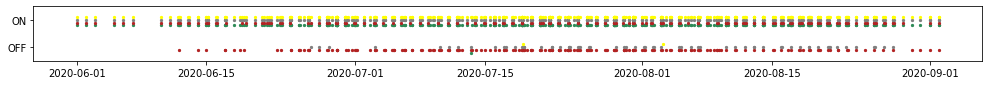

In [256]:
fig, ax = plt.subplots(figsize=(17,1))
colors = ['seagreen','firebrick','grey','yellow']
jitter = -0.2
for variable, c in zip(['tvoc','no2','pm2p5_mass','lux'],colors):
    temp = df[df[variable] > -1000]
    temp['values'] = np.ones(len(temp))
    temp.index = pd.to_datetime(temp.index)
    bad = df[np.isnan(df[variable])]
    bad['values'] = np.zeros(len(bad))
    bad.index = pd.to_datetime(bad.index)
    ax.scatter(temp.index,temp['values']+jitter,color=c,s=5)
    ax.scatter(bad.index,bad['values']+jitter,color=c,s=5)
    jitter += 0.1

ax.set_ylim([-0.5,1.5])
ax.set_yticks([0,1])
ax.set_yticklabels(['OFF','ON'])
plt.show()
plt.close()

#### Per Participant
Now we see how many nights were recorded for each beacon.

In [257]:
def plot_data_availability_by_beacon(df):
    '''
    Plots a stripplot plot of the number of nights each beacon was operating for by sensor
    
    Inputs:
    - df: dataframe with columns in columns_to_use
    
    Returns void
    '''
    columns_to_use = ['lux','tvoc','co2','co','no2','pm1_mass','pm2p5_mass','pm10_mass','beacon','start_time']
    df_filtered = df[columns_to_use]
    data = {'lux':[],'tvoc':[],'co2':[],'co':[],'no2':[],'pm1_mass':[],'pm2p5_mass':[],'pm10_mass':[],'beacon':[]}
    for bb in df_filtered['beacon'].unique():
        df_by_bb = df_filtered[df_filtered['beacon'] == bb]
        df_by_bb_by_night = df_by_bb.groupby('start_time').mean()
        for var in columns_to_use:
            if var == 'start_time':
                pass
            elif var == 'beacon':
                data['beacon'].append(bb)
            else:
                data[var].append(df_by_bb_by_night.count()[var])

    df_count = pd.DataFrame(data)
    df_to_plot = df_count.melt(id_vars=['beacon'],value_vars=['lux','tvoc','co2','co','no2','pm1_mass','pm2p5_mass','pm10_mass'],
                              var_name='Variable', value_name='Number of Nights')
    fig, ax = plt.subplots(figsize=(12,6))
    sns.stripplot(x='Variable',y='Number of Nights',hue='beacon',data=df_to_plot,size=7.5,jitter=0.25,ax=ax,
                 marker='o')
    
    ax.set_xticklabels(['Light','TVOC','CO$_2$','CO','NO$_2$','PM$_1$','PM$_{2.5}$','PM$_{10}$'])
    for loc in ['right','top','bottom']:
        ax.spines[loc].set_visible(False)
    
    ax.legend(bbox_to_anchor=(1.08,1),frameon=False)
        
    plt.show()
    plt.close()
    

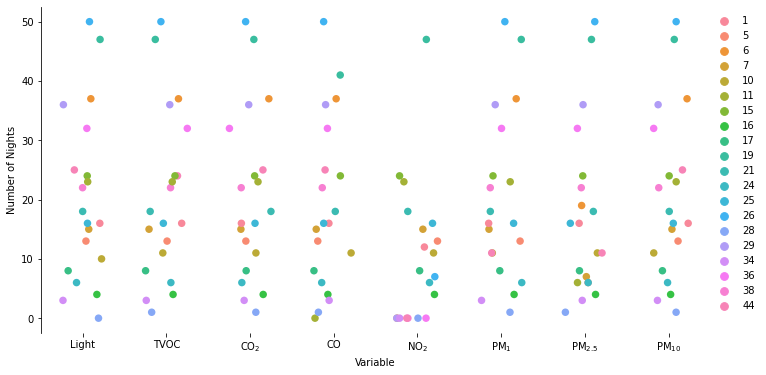

In [258]:
plot_data_availability_by_beacon(beacon_fitbit)

## Percent of Possible Data while Asleep, At Home, and Completed Survey
Now we look at the smallest window of the nightly measured values.

In [261]:
beacon_filtered_important = beacon_filtered[variables]
temp = beacon_filtered_important.drop(['beacon'],axis=1).dropna(how='all')
night_op_df = pd.DataFrame()
night_op_df['n'] = temp.count()
night_op_df['max_n'] = len(temp)
night_op_df['percent'] = temp.count()/len(temp)

Again, considering NO2

In [262]:
no2_temp = beacon_filtered_important[beacon_filtered_important['beacon'].isin(no2_beacons)].drop(['beacon'],axis=1).dropna(how='all')
night_op_df.loc['no2','max_n'] = len(no2_temp)
night_op_df.loc['no2','percent'] = night_op_df.loc['no2','n'] / len(no2_temp)
night_op_df

,n,max_n,percent
lux,16901,17634,0.958433
tvoc,17491,17634,0.991891
co2,16913,17634,0.959113
co,15157,17634,0.859533
no2,9083,10685,0.850070
pm2p5_mass,14990,17634,0.850062


In [263]:
total_n = night_op_df['n'].sum()
total_max_n = night_op_df['max_n'].sum()
print(f'Total Percent Complete: {total_n/total_max_n}')

Total Percent Complete: 0.9158363259319204


Adding to overall operation

In [264]:
overall_op['Asleep, Home, and EMA'] = list(np.around(night_op_df['percent'].values*100,1))
overall_op['Asleep, Home, and EMA'].append(round(total_n/total_max_n*100,1))

### Number of nights recorded under this scheme

#### Aggregate
Overall number of nights measured when EMAs are added the mix

In [265]:
df = beacon_filtered.groupby(['start_time']).mean()
df = df[variables]
df.drop('beacon',axis=1,inplace=True)
print('Number of Nights Measured:',len(df.dropna(how='all')))

Number of Nights Measured: 227


Number of nights and beacons capturing data when considering EMAs in addition to Fitbit and GPS

In [266]:
vars_to_check = ['lux','tvoc','co2','co','no2','pm2p5_mass']
for variable in vars_to_check:
    sensor_df = beacon_filtered[[variable,'start_time','beacon']]
    sensor_df.dropna(inplace=True)
    print(f'Number of Nights for {variable}:',len(sensor_df['start_time'].unique()))
    print(f'Number of Beacons:', len(sensor_df['beacon'].unique()))

Number of Nights for lux: 225
Number of Beacons: 18
Number of Nights for tvoc: 227
Number of Beacons: 19
Number of Nights for co2: 227
Number of Beacons: 19
Number of Nights for co: 218
Number of Beacons: 18
Number of Nights for no2: 115
Number of Beacons: 12
Number of Nights for pm2p5_mass: 196
Number of Beacons: 19


#### By beacon

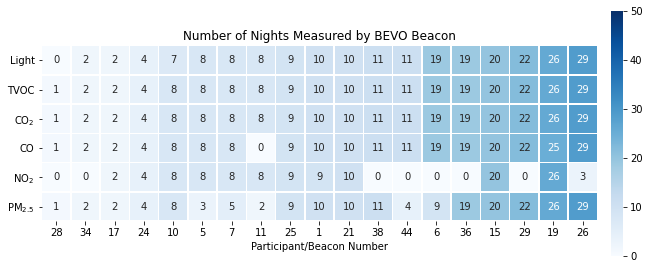

In [267]:
fully_filtered_nights = plot_data_availability_heatmap(beacon_filtered, df_filter='fully', save=True, save_dir="../../papers/5eea5276044b790001ee5687/figures/")

## Combining Percentages
Putting them all together.

In [268]:
indices = ['lux',
 'tvoc',
 'co2',
 'co',
 'no2',
 'pm2p5_mass',
 'total']
pd.DataFrame(overall_op, index=indices)

,During Study,While Operating,Asleep and Home,"Asleep, Home, and EMA"
lux,194.5,90.6,96.5,95.8
tvoc,211.2,98.5,98.8,99.2
co2,207.7,96.8,95.4,95.9
co,198.2,92.4,82.6,86.0
no2,176.5,89.5,83.7,85.0
pm2p5_mass,176.3,82.2,81.7,85.0
total,195.0,91.8,90.2,91.6


# Miscellaneous

## Converting NO2
The literature is split on the units they use to report NO2 concentrations.

In [ ]:
def convert_no2_to_ppb(concentration):
    '''
    Converts a ug/m3 NO2 concentration to ppb
    '''
    
    MM = 46 #g/mol
    MV = 24.5 #L/mol
    
    return concentration*MV/MM

In [ ]:
def convert_no2_to_ugm3(concentration):
    '''
    Converts a ppb NO2 concentration to ug/m3
    '''
    
    MM = 46 #g/mol
    MV = 24.5 #L/mol
    
    return concentration*MM/MV

In [ ]:
convert_no2_to_ppb(16.2)

In [ ]:
convert_no2_to_ugm3(13.8)